In [32]:
# 라이브러리 호출
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from functools import reduce
from datetime import datetime, timezone
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss, TomekLinks
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from joblib import dump
# 경고 무시
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import warnings
warnings.filterwarnings('ignore')

In [5]:
prep_data = pd.read_csv("data/prep_data.csv")
prep_data

,tier,rank,winRate,veteran,freshBlood,hotStreak,revisionDate,summonerLevel,championId,championLevel,championPoints,lastPlayTime,championSeasonMilestone,churn
0,0,2,22.222222,0,0,0,41,38,64,5,29339,70,0,1
1,0,2,22.222222,0,0,0,41,38,76,5,28572,70,0,1
2,0,2,22.222222,0,0,0,41,38,92,5,24741,109,0,1
3,2,3,57.692308,0,0,0,3,181,81,20,196312,36,0,0
4,2,3,57.692308,0,0,0,3,181,145,20,190530,20,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694170,9,0,27.272727,0,0,0,5,394,64,21,214339,7,1,0
694171,9,0,27.272727,0,0,0,5,394,350,12,103144,48,0,0
694172,8,0,62.222222,0,1,0,3,382,80,34,416320,2,7,0
694173,8,0,62.222222,0,1,0,3,382,28,29,330003,7,1,0


#### 오버샘플링

In [6]:
columns = ["hotStreak","veteran", "freshBlood", "churn"] # "veteran", "freshBlood", "churn"
oversampl_X_data = prep_data.copy()
smote = SMOTE(random_state=42)

for column in columns:
    oversampl_y_data = oversampl_X_data[column]
    oversampl_X_data = oversampl_X_data.drop(labels=column, axis=1)
    
    oversampl_X_data, oversampl_y_data = smote.fit_resample(oversampl_X_data, oversampl_y_data)
    oversampl_X_data = pd.concat([oversampl_X_data, oversampl_y_data], axis=1)

oversampl_data = oversampl_X_data

veteran
0    8206481
1    1265515
Name: count, dtype: int64
freshBlood
0    7052877
1    2419119
Name: count, dtype: int64
hotStreak
0    7623494
1    1848502
Name: count, dtype: int64
churn
1    4735998
0    4735998
Name: count, dtype: int64


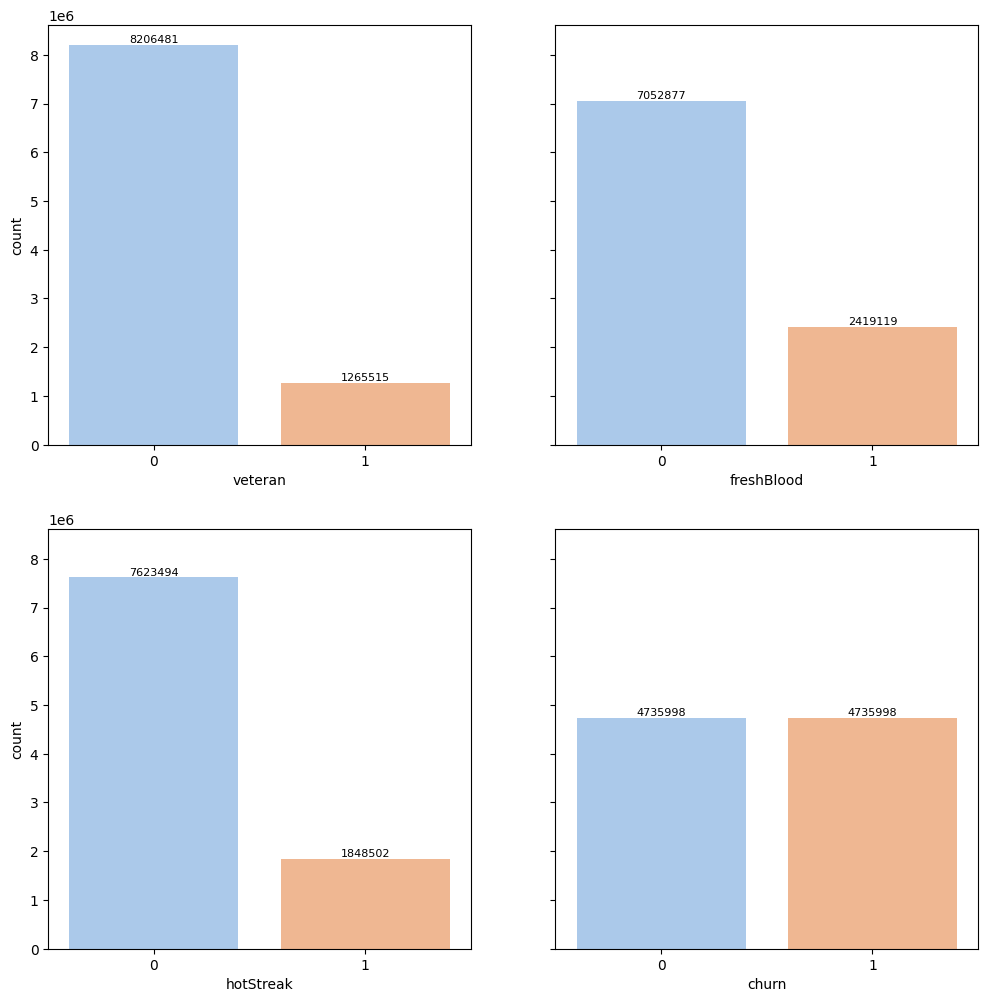

In [7]:
print(oversampl_data["veteran"].value_counts())
print(oversampl_data["freshBlood"].value_counts())
print(oversampl_data["hotStreak"].value_counts())
print(oversampl_data["churn"].value_counts())

cols = ['veteran', 'freshBlood', 'hotStreak', "churn"]

fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharey=True)

for ax, col in zip(axes.flatten(), cols):
    sns.countplot(data=oversampl_data, x=col, ax=ax, palette="pastel")
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', 
                    va='bottom',
                    fontsize=8, 
                    color='black')
plt.show()

#### 언더샘플링

In [12]:
columns = ["veteran", "freshBlood","hotStreak","churn"] # "veteran", "freshBlood", "churn"
undersampl_X_data = oversampl_data.copy()
tomek = TomekLinks(sampling_strategy='majority')

for column in columns:
    underampl_y_data = undersampl_X_data[column]
    undersampl_X_data = undersampl_X_data.drop(labels=column, axis=1)
    
    undersampl_X_data, underampl_y_data = tomek.fit_resample(undersampl_X_data, underampl_y_data)
    undersampl_X_data = pd.concat([undersampl_X_data, underampl_y_data], axis=1)

undersampl_data = undersampl_X_data

veteran
0    8168251
1    1265078
Name: count, dtype: int64
freshBlood
0    7021192
1    2412137
Name: count, dtype: int64
hotStreak
0    7592382
1    1840947
Name: count, dtype: int64
churn
1    4728002
0    4705327
Name: count, dtype: int64


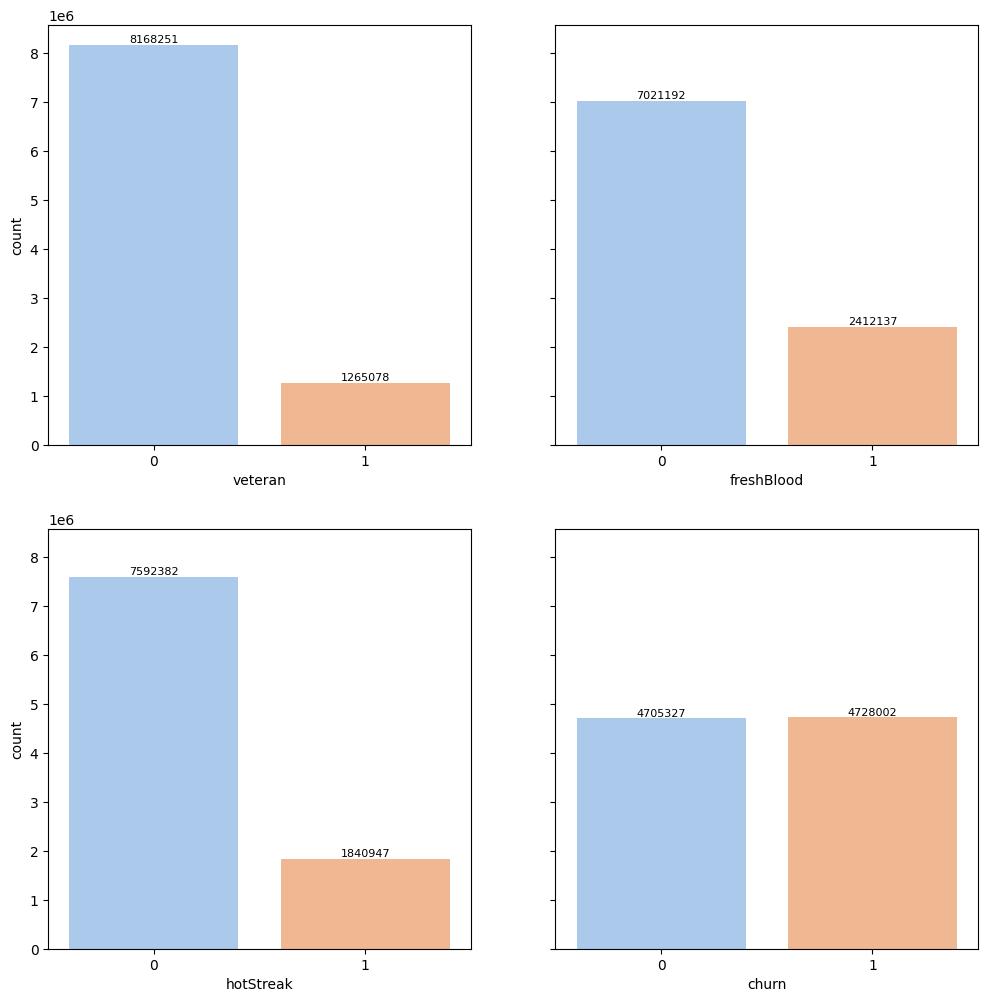

In [13]:
print(undersampl_data["veteran"].value_counts())
print(undersampl_data["freshBlood"].value_counts())
print(undersampl_data["hotStreak"].value_counts())
print(undersampl_data["churn"].value_counts())

cols = ['veteran', 'freshBlood', 'hotStreak', "churn"]

fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharey=True)

for ax, col in zip(axes.flatten(), cols):
    sns.countplot(data=undersampl_data, x=col, ax=ax, palette="pastel")
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', 
                    va='bottom',
                    fontsize=8, 
                    color='black')
plt.show()

In [14]:
input_data_x = undersampl_data.drop(["churn", "revisionDate"], axis=1)
input_data_y = undersampl_data["churn"]

X_train, X_test, y_train, y_test = train_test_split(input_data_x, input_data_y, test_size=.25)


## 기본

In [15]:
rf_clf = RandomForestClassifier(n_estimators=200, max_depth=9, min_samples_leaf=18, min_samples_split=8)

rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, min_samples_leaf=18, min_samples_split=8,
                       n_estimators=200)

In [16]:
y_pred_train = rf_clf.predict(X_train)
acc_score_train = accuracy_score(y_train, y_pred_train)
f1_score_train = f1_score(y_train, y_pred_train)
print(f'평가 정확도: {acc_score_train}')
print(f'평가 f1 score: {f1_score_train}')
print("------------------------------------------------")
print(" ")
print(" ")
print(" ")
print(" ")
y_pred_test = rf_clf.predict(X_test)
acc_score_test = accuracy_score(y_test, y_pred_test)
f1_score_test = f1_score(y_test, y_pred_test)
print(f'random_forest 정확도: {acc_score_test}')
print(f'random_forest f1 score: {f1_score_test}')

평가 정확도: 0.9504262617250949
평가 f1 score: 0.9523879079453037
------------------------------------------------
 
 
 
 
random_forest 정확도: 0.950248332190577
random_forest f1 score: 0.9522223756023053


In [84]:
from sklearn.model_selection import GridSearchCV
params = {
    'n_estimators':[200, 300, 400],
    'max_depth' : [6, 8, 7, 9], 
    'min_samples_leaf' : [8, 12, 18],
    'min_samples_split' : [8, 16, 20]
}

rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf , param_grid=params , cv=2, n_jobs=2, verbose=2 )
grid_cv.fit(X_train , y_train) # grid.cv.fit(train_x, train_y)

estimator =grid_cv.best_estimator_ 
pred = estimator.predict(X_test) # estimator.predict(test)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))
acc_score_test(y_test , pred)

Fitting 2 folds for each of 108 candidates, totalling 216 fits
최적 하이퍼 파라미터:
 {'max_depth': 9, 'min_samples_leaf': 18, 'min_samples_split': 8, 'n_estimators': 200}
최고 예측 정확도: 0.9506


TypeError: 'float' object is not callable

# 트리 시각화

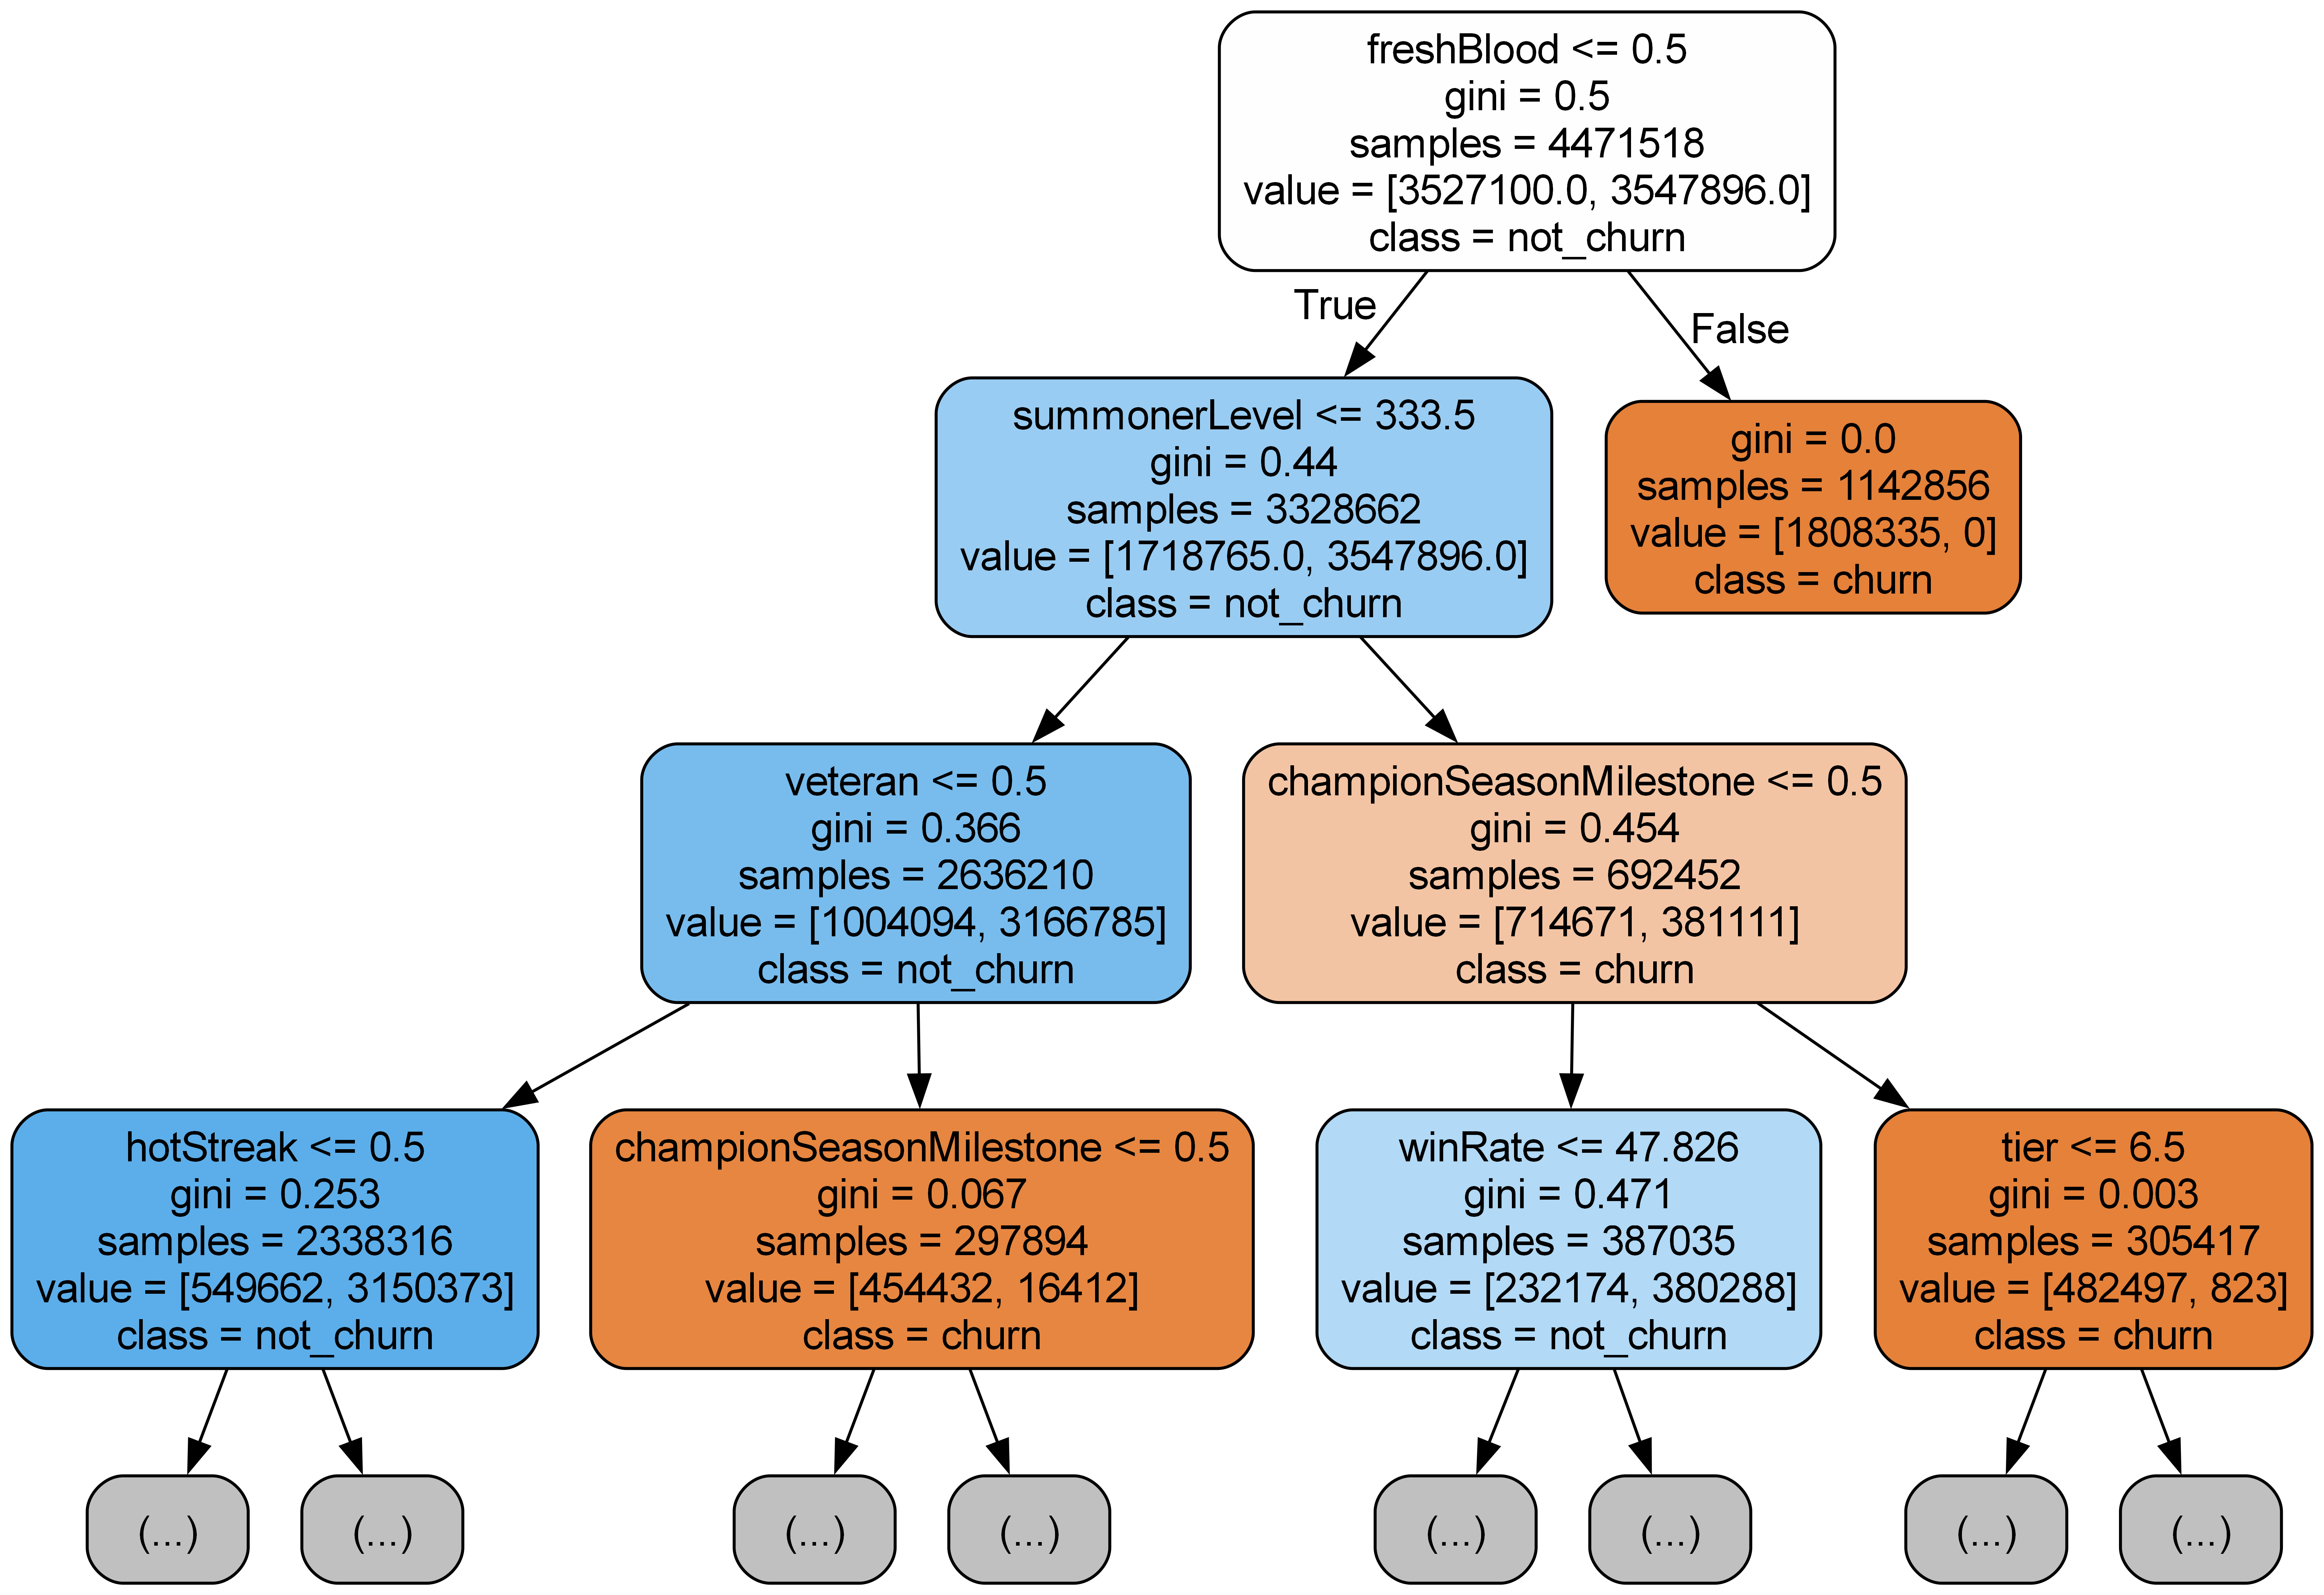

In [29]:
from sklearn.tree import export_graphviz

estimator = rf_clf.estimators_[3]

export_graphviz(estimator, out_file="tree.dot",
                feature_names = input_data_x.columns,
                class_names = ["churn", "not_churn"],
                max_depth = 3,
                precision = 3,
                filled = True,
                rounded=True,
               )

# 생성된 .dot 파일을 .png로 변환
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'random_forest.png', '-Gdpi=600'])

# jupyter notebook에서 .png 직접 출력
from IPython.display import Image
Image(filename = 'random_forest.png')

# 특성 중요도 시각화

In [30]:
feat_imptc_ser = pd.Series(rf_clf.feature_importances_, index=input_data_x.columns).sort_values(ascending=False)
feat_imptc_ser

lastPlayTime               0.358508
freshBlood                 0.274126
championSeasonMilestone    0.170647
veteran                    0.085213
summonerLevel              0.036073
hotStreak                  0.022483
championLevel              0.015400
rank                       0.012819
championPoints             0.010218
winRate                    0.008777
tier                       0.004645
championId                 0.001091
dtype: float64

<Axes: xlabel='None', ylabel='None'>

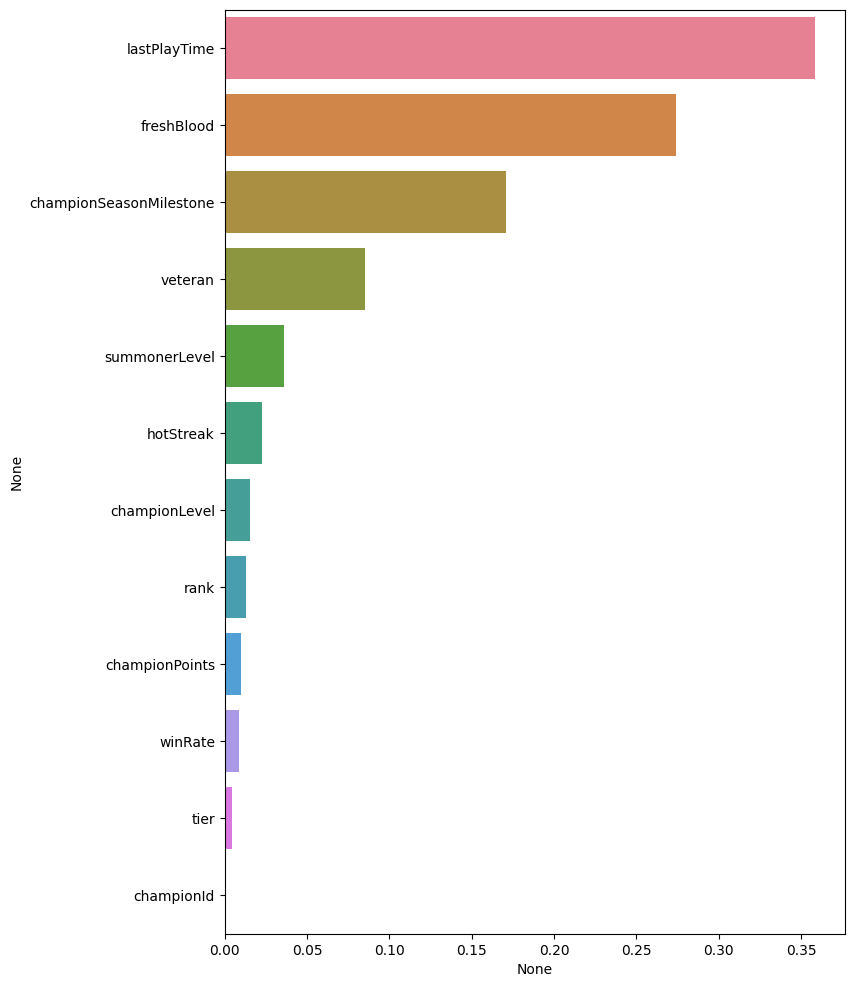

In [31]:
plt.figure(figsize=(8, 12))
sns.barplot(
    x = feat_imptc_ser,
    y = feat_imptc_ser.index,
    hue = feat_imptc_ser.index
)

# Model 저장

In [34]:
dump(rf_clf, "random_forest.joblib")  # 모델 저장

['random_forest.joblib']